<a href="https://colab.research.google.com/github/Tlen33/Object-Detection-YOLOv3-/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BA%D0%B0_Object_Detection_(YOLOv3)%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Импорт библиотек

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ZeroPadding2D, Add, UpSampling2D, Concatenate, Lambda, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from PIL import Image, ImageDraw, ImageFont
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from google.colab import files
import tensorflow.keras.backend as K
import math
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import keras
import cv2
import sys

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# Подключение диска

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Основные параметры

path = '/content/drive/MyDrive/Colab Notebooks/Базы/Airplanes/'
name_classes = ['Самолеты']
num_classes = len(name_classes)
input_shape = (416, 416)

anchors = np.array([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]]) 
num_anchors = len(anchors)

In [ ]:
# Функции создания модели

def create_model(input_shape, num_anchors, use_weights = False, weights_path = 'yolo.h5'):
    w, h = input_shape
    inputs = Input(shape = (w, h, 3))
    y_true = [Input (shape = (w // 32, h // 32, num_anchors // 3, num_classes + 5))]
    y_true.append (Input (shape = (w // 16, h // 16, num_anchors // 3, num_classes + 5)))
    y_true.append (Input (shape = (w // 8, h // 8, num_anchors // 3, num_classes + 5)))
    
    model_yolo = create_YOLOv3(inputs, num_anchors // 3)
    print ('Создана модель YOLOv3. Количество классов: {}.'.format(num_classes))

    if use_weights:
        model_yolo.load_weights(weights_path, by_name = False, skip_mismatch = False)
        print ('Загружены веса из файла {}.'.format(weights_path))

    outputs = Lambda(yolo_loss, output_shape = (1,), name = 'yolo_loss', arguments = {'num_anchors' : num_anchors}) ([*model_yolo.output, *y_true])
    
    return Model([inputs, *y_true], outputs)

def create_YOLOv3(inputs, num_sub_anchors):
    x = ConvBL (inputs, 32, (3, 3))
    x = resblock (x, 64, 1)
    x = resblock (x, 128, 2)
    x = resblock (x, 256, 8)
    x = resblock (x, 512, 8)
    x = resblock (x, 1024, 4)
    base_model = Model(inputs, x)

    x = ConvBL(base_model.output, 512, (1, 1))    
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))

    y1 = ConvBL(x, 1024, (3,3))
    y1 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y1)

    x = ConvBL(x, 256, ( 1, 1)) 
    x = UpSampling2D(2) (x)
    x = Concatenate()([x,base_model.layers[152].output])

    x = ConvBL(x, 256, (1, 1))  
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))

    y2 = ConvBL(x, 512, (3, 3))
    y2 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y2)

    x = ConvBL(x, 128, ( 1, 1))
    x = UpSampling2D(2) (x)
    x = Concatenate()([x,base_model.layers[92].output])

    x = ConvBL(x, 128, (1, 1))  
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))

    y3 = ConvBL(x, 256, (3, 3))
    y3 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y3)
    
    return Model(inputs, [y1, y2, y3])

def resblock(inputs, num_filters, num_blocks):
    x = ZeroPadding2D(((1, 0), (1, 0)))(inputs)
    x = ConvBL(x, num_filters, (3, 3), strides=(2, 2))
    for i in range(num_blocks):
        y = ConvBL(x, num_filters // 2, (1, 1))
        y = ConvBL(y, num_filters, (3, 3))
        x = Add() ([x, y])
    return x

def ConvBL(inputs, *args, **kwargs): 
    new_kwargs = {'use_bias': False}
    new_kwargs['kernel_regularizer'] = l2(5e-4)
    new_kwargs['padding'] = 'valid' if kwargs.get('strides') == (2, 2) else 'same'
    new_kwargs.update(kwargs)
    x = Conv2D(*args, **new_kwargs) (inputs)
    x = BatchNormalization() (x)
    x = LeakyReLU(alpha=0.1) (x)
    return x

def yolo_loss(inputs, num_anchors):
    ignore_thresh = .5
    num_layers = num_anchors // 3
    y_pred = inputs[:num_layers]
    y_true = inputs[num_layers:]
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    input_shape = K.cast(K.shape(y_pred[0])[1:3] * 32, K.dtype(y_true[0])) 
    grid_shapes = [K.cast(K.shape(y_pred[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
    
    loss = 0
    m = K.shape(y_pred[0])[0]
    batch_size = K.cast(m, K.dtype(y_pred[0]))
    
    for l in range(num_layers):
        object_mask = y_true[l][..., 4:5]
        true_class = y_true[l][..., 5:]   
        num_sub_anchors = len(anchors[anchor_mask[l]])
        anchors_tensor = K.reshape(K.constant(anchors[anchor_mask[l]]), [1, 1, 1, num_sub_anchors, 2])
        grid_shape = K.shape(y_pred[l])[1:3]
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),[1, grid_shape[1], 1, 1])
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),[grid_shape[0], 1, 1, 1])
        grid = K.concatenate([grid_x, grid_y])
        grid = K.cast(grid, K.dtype(y_pred[l]))
        feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, num_classes + 5])
        pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
        true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid
        box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4]
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)
        pred_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats)) 
        true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1]) 
        true_wh = K.switch(object_mask, true_wh, K.zeros_like(true_wh)) 
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(true_wh-feats[...,2:4])

        pred_box = K.concatenate([pred_xy, pred_wh]) 
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True) 
        object_mask_bool = K.cast(object_mask, 'bool')

        def loop_body(b, ignore_mask):
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0])
            iou = calc_iou(pred_box[b], true_box)
            best_iou = K.max(iou, axis=-1)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou < ignore_thresh, K.dtype(true_box))) 
            return b+1, ignore_mask

        _, ignore_mask = tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask]) 
        ignore_mask = ignore_mask.stack()
        ignore_mask = K.expand_dims(ignore_mask, -1)
        confidence_loss = (
            object_mask * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) +
            (1-object_mask) * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) * ignore_mask
            )

        class_loss = object_mask * K.binary_crossentropy(true_class, feats[...,5:], from_logits=True)
        xy_loss = K.sum(xy_loss) / batch_size
        wh_loss = K.sum(wh_loss) / batch_size
        confidence_loss = K.sum(confidence_loss) / batch_size
        class_loss = K.sum(class_loss) / batch_size
        loss += xy_loss + wh_loss + confidence_loss + class_loss

    return loss

def calc_iou(input1, input2):
    input1 = K.expand_dims(input1, -2)
    xy1 = input1[..., :2]
    wh1 = input1[..., 2:4]
    wh_half1 = wh1 / 2.
    top_left1 = xy1 - wh_half1
    right_bottom1 = xy1 + wh_half1
    
    input2 = K.expand_dims(input2, 0)
    xy2 = input2[..., :2]
    wh2 = input2[..., 2:4]
    wh_half2 = wh2 / 2.
    top_left2 = xy2 - wh_half2
    right_bottom2 = xy2 + wh_half2
    
    intersect_mins = K.maximum(top_left1, top_left2)
    intersect_maxes = K.minimum(right_bottom1, right_bottom2)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]

    area1 = wh1[..., 0] * wh1[..., 1]
    area2 = wh2[..., 0] * wh2[..., 1]

    return intersect_area / (area1 + area2 - intersect_area)

In [ ]:
# Создаем модель

model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path='/content/drive/MyDrive/Colab Notebooks/Базы/YOLOv3__el1000__opt0.00001__ep0_100.h5')

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/MyDrive/Colab Notebooks/Базы/YOLOv3__el1000__opt0.00001__ep0_100.h5.


In [ ]:
# Выводим входные размерности

model_YOLO.input

[<KerasTensor: shape=(None, 416, 416, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 13, 13, 3, 6) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 26, 26, 3, 6) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 52, 52, 3, 6) dtype=float32 (created by layer 'input_4')>]

In [ ]:
# Выводим выходныую размерность

model_YOLO.output

<KerasTensor: shape=() dtype=float32 (created by layer 'yolo_loss')>

In [ ]:
# Выводим информацию о модели

model_YOLO.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 416, 416, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 416, 416, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

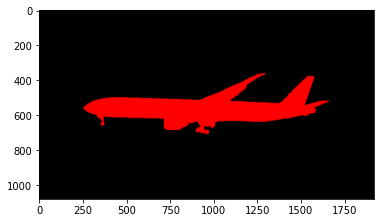

In [ ]:
# Открываем файл сегментированной модели

filename = 'airplane_65'
image = Image.open(path+'Segment/'+filename+'.jpg')
img1 = ImageDraw.Draw(image)
plt.imshow(image)

minX = 248    minY = 358    maxX = 1665    maxY = 711


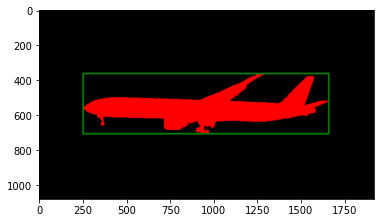

In [ ]:
# Находим координаты ограничивающего бокса

image_n = np.array(image)
image_red = image_n[:,:,0]
itemindex = np.array(np.where(image_red > 20 ))

minY = min (itemindex[0])
maxY = max (itemindex[0])
minX = min (itemindex[1])
maxX = max (itemindex[1])
print ('minX = ',minX, '    minY = ', minY, '    maxX = ', maxX, '    maxY = ',maxY, sep='')

for i in range(10):
  img1.rectangle([minX+i,minY+i,maxX-i,maxY-i], outline = 'green')
plt.imshow(image)

In [ ]:
# Запишем всю информацию в словарь

dictionary = {}
class_id = 0
key = filename
dictionary[key] = 'Air/'+key+'.jpg'+' '+str(minX)+','+str(minY)+','+str(maxX)+','+str(maxY)+','+str(class_id)
print (dictionary)

{'airplane_65': 'Air/airplane_65.jpg 248,358,1665,711,0'}


Размер исходного изображения:  1920 1080
Размерность входных данных для модели: 416 416
Параметры ограничивающей рамки [[ 248  358 1665  711    0]]


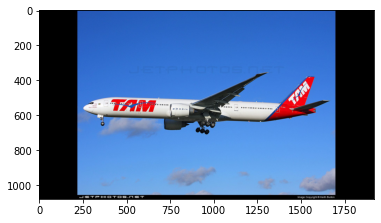

In [ ]:
# Загружаем оригинальное изображение

line = dictionary[filename].split()
image = Image.open(path+line[0])
iw, ih = image.size
w, h = (416,416)
box = np.array([np.array(list(map(lambda x: int((float)(x)),box.split(',')))) for box in line[1:]])
plt.imshow(image)
print ('Размер исходного изображения: ',iw, ih)
print ('Размерность входных данных для модели:', h, w)
print ('Параметры ограничивающей рамки', box)

Коэффициент масштабирования:  0.7778461704905045
Новый размер изображения:  323 280


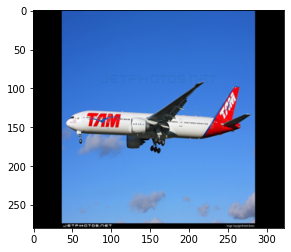

In [ ]:
# Аугментация изображения

def rand(a = 0, b = 1):
  return np.random.rand() * (b - a) + a

jitter = .3
hue = .1
sat = 1.5
val = 1.5

new_ar = w / h * rand(1 - jitter, 1 + jitter) / rand(1 - jitter, 1 + jitter)
scale = rand(.65, 2) 
print ('Коэффициент масштабирования: ', scale)

if new_ar < 1:
    nh = int(scale * h)
    nw = int(nh * new_ar)
else:
    nw = int(scale * w)
    nh = int(nw / new_ar)
print ('Новый размер изображения: ',nw, nh)
image1 = image.resize((nw,nh), Image.BICUBIC)
plt.imshow(image1)

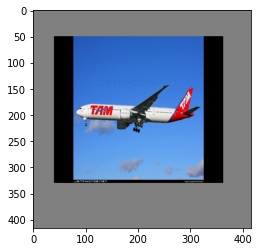

In [ ]:
# Приводим к размеру 416 на 416 пикселей

dx = int(rand(0, w - nw))
dy = int(rand(0, h - nh))
new_image = Image.new('RGB', (w, h), (128,128,128))
new_image.paste(image1, (dx, dy))
image2 = new_image
plt.imshow(image2)

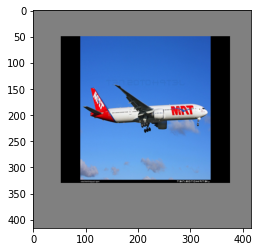

In [ ]:
# Случаным образом отображаем изображение по горизонтале

flip = rand() < .5
if flip: 
    image2 = image2.transpose(Image.FLIP_LEFT_RIGHT)
plt.imshow(image2)

(416, 416, 3)


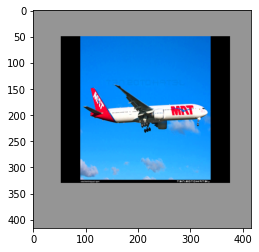

In [ ]:
# Случайным образом меняем освещенность, экспозицию, гамму изображения

hue1 = rand(-hue, hue)
sat1 = rand(1, sat) if rand() < .5 else 1 / rand(1, sat)
val1 = rand(1, val) if rand() < .5 else 1 / rand(1, val)
x = rgb_to_hsv(np.array(image2) / 255.)
x[..., 0] += hue1
x[..., 0][x[..., 0] > 1] -= 1
x[..., 0][x[..., 0] < 0] += 1
x[..., 1] *= sat1
x[..., 2] *= val1
x[x > 1] = 1
x[x < 0] = 0
image_data = hsv_to_rgb(x)
print (image_data.shape)
plt.imshow(image_data)

[ 96. 142. 335. 234.   0.]


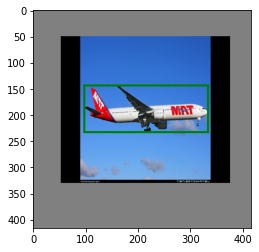

In [ ]:
# Корректируем параметры ограничивающей рамки

max_boxes = 5
box_data = np.zeros((max_boxes,5))
box_mod = box.copy()
box_mod[:, [0,2]] = box_mod[:, [0,2]] * nw / iw + dx
box_mod[:, [1,3]] = box_mod[:, [1,3]] * nh / ih + dy

if flip: 
    box_mod[:, [0,2]] = w - box_mod[:, [2,0]]
box_mod[:, 0:2][box_mod[:, 0:2] < 0] = 0
box_mod[:, 2][box_mod[:, 2] > w] = w
box_mod[:, 3][box_mod[:, 3] > h] = h
box_w = box_mod[:, 2] - box_mod[:, 0] 
box_h = box_mod[:, 3] - box_mod[:, 1]
box_mod = box_mod[np.logical_and(box_w > 1, box_h > 1)]

if len(box_mod) > max_boxes: 
    box_mod = box_mod[:max_boxes]
box_data[:len(box_mod)] = box_mod
print(box_data[0])
img1 = ImageDraw.Draw(image2)
for i in range(4):
    img1.rectangle([box_data[0][0] + i, box_data[0][1] + i, box_data[0][2] - i, box_data[0][3] - i], outline = 'green')
plt.imshow(image2)

In [ ]:
num_layers = 3
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]
   
real_boxes = np.array(box_data, dtype='float32')
input_shape = np.array((416,416), dtype='int32')

boxes_xy = (real_boxes[:,0:2] + real_boxes[:,2:4]) // 2
boxes_wh = real_boxes[..., 2:4] - real_boxes[..., 0:2]

print('Центр ограничивающей рамки: ', boxes_xy[0])
print('Ширина и высота ограничивающей рамки:', boxes_wh[0])

Центр ограничивающей рамки:  [215. 188.]
Ширина и высота ограничивающей рамки: [239.  92.]


In [ ]:
# Переводим параметры ограничивающей рамки в относительные координаты (от 0 до 1)

real_boxes[:, 0:2] = boxes_xy/input_shape[0]
real_boxes[:, 2:4] = boxes_wh/input_shape[1]
print(real_boxes[0])

[0.5168269  0.45192307 0.5745192  0.22115384 0.        ]


In [ ]:
# Создадим заготовку под входные слои y_true

cells = [13,26,52]
y_true = [np.zeros((cells[l],cells[l],len(anchor_mask[l]),5+num_classes),dtype='float32') for l in range(num_layers)]
print(y_true[0].shape)
print(y_true[1].shape)
print(y_true[2].shape)

(13, 13, 3, 6)
(26, 26, 3, 6)
(52, 52, 3, 6)


In [ ]:
# Площадь, занятая ограничивающей рамкой

wh = boxes_wh[0, :]
box_area = wh[0] * wh[1]
print (wh[0],'*',wh[1],'=', box_area)

239.0 * 92.0 = 21988.0


In [ ]:
# Площади, которые занимаю анкоры

anchor_area = anchors[:, 0] * anchors[:, 1]
print (anchor_area)

[   130    480    759   1830   2790   7021  10440  30888 121598]


In [ ]:
# Получим новые параметры анкоров, значения которых не превышают значения высоты и ширины ограничивающей рамки

correct_anchors = []

for elem in anchors:
    correct_anchors.append ([min(elem[0], wh[0]), min(elem[1], wh[1])])
correct_anchors = np.array(correct_anchors)
print(correct_anchors)
correct_anchors_area = correct_anchors[:,0] * correct_anchors[:,1]
print(correct_anchors_area)

[[ 10.  13.]
 [ 16.  30.]
 [ 33.  23.]
 [ 30.  61.]
 [ 62.  45.]
 [ 59.  92.]
 [116.  90.]
 [156.  92.]
 [239.  92.]]
[  130.   480.   759.  1830.  2790.  5428. 10440. 14352. 21988.]


In [ ]:
# Подсчитвываем iou всех вариантов

iou = correct_anchors_area / (box_area + anchor_area - correct_anchors_area)
print(iou)

[0.00591232 0.02183009 0.03451883 0.08322721 0.12688739 0.23018532
 0.47480444 0.37254698 0.18082534]


In [ ]:
# Определяем позицию лучшего анкора

best_anchor = np.argmax(iou, axis=-1)
print (best_anchor)

6


In [ ]:
# Параметры ограничивающей рамки

print('Параметры ограничивающей рамки',real_boxes[0])
for l in range(num_layers):
    if best_anchor in anchor_mask[l]:
        print('Уровень анкора =',l)
        i = np.floor(real_boxes[0,0]*cells[l]).astype('int32')
        print ('i =',i)    
        j = np.floor(real_boxes[0,1]*cells[l]).astype('int32')
        print ('j =',j)    
        k = anchor_mask[l].index(best_anchor)
        print('Номер поданкора =',k)    
        c = real_boxes[0, 4].astype('int32')
        print ('Номер класса =',c)    
        y_true[l][j, i, k, 0:4] = real_boxes[0, 0:4]
        y_true[l][j, i, k, 4] = 1
        y_true[l][j, i, k, 5+c] = 1
        break

print(y_true[l][j,i,...])

Параметры ограничивающей рамки [0.5168269  0.45192307 0.5745192  0.22115384 0.        ]
Уровень анкора = 0
i = 6
j = 5
Номер поданкора = 0
Номер класса = 0
[[0.5168269  0.45192307 0.5745192  0.22115384 1.         1.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]


In [ ]:
# Функция генерации данных

def data_generator(annotation_lines, batch_size, anchors, input_shape):
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = augmentation(annotation_lines[i])
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = get_y(box_data, anchors, input_shape)    
        yield [image_data, *y_true], np.zeros(batch_size)

# Случайная аугментация изображения

def augmentation(data):
    params = {
        'jitter' : .3,
        'hue'    : .1,
        'sat'    : 1.5,
        'val'    : 1.5
    }
    data = data.split()
    image = Image.open(path + data[0])
    width_i, height_i = image.size
    widht_shape, height_shape = input_shape[:2]

    box = np.array([np.array(list(map(lambda x: int(float(x)),box.split(',')))) for box in data[1:]])

    new_ar = widht_shape / height_shape * rand(1 - params['jitter'], 1 + params['jitter']) / rand(1 - params['jitter'], 1 + params['jitter'])
    scale = rand(.65, 2) 
    if new_ar < 1:        
        nh = int(scale * height_shape)
        nw = int(nh * new_ar)
    else:
        nw = int(scale * widht_shape)
        nh = int(nw / new_ar)
    image = image.resize((nw, nh), Image.BICUBIC)

    dx = int(rand(0, widht_shape - nw))
    dy = int(rand(0, height_shape - nh))
    new_image = Image.new('RGB', (widht_shape, height_shape), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image

    flip = rand() < .5
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    hue1 = rand(-params['hue'], params['hue'])
    sat1 = rand(1, params['sat']) if rand() < .5 else 1 / rand(1, params['sat'])
    val1 = rand(1, params['val']) if rand() < .5 else 1 / rand(1, params['val'])
    x = rgb_to_hsv(np.array(image) / 255.)
    x[..., 0] += hue1
    x[..., 0][x[..., 0] > 1] -= 1
    x[..., 0][x[..., 0] < 0] += 1
    x[..., 1] *= sat1
    x[..., 2] *= val1
    x[x > 1] = 1
    x[x < 0] = 0
    image_data = hsv_to_rgb(x)
    
    max_boxes = 4
    box_data = np.zeros((max_boxes,5))
    if len(box)>0:
        box[:, [0,2]] = box[:, [0,2]] * nw/width_i + dx
        box[:, [1,3]] = box[:, [1,3]] * nh/height_i + dy
        if flip: box[:, [0,2]] = widht_shape - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        box[:, 2][box[:, 2] > widht_shape] = widht_shape
        box[:, 3][box[:, 3] > height_shape] = height_shape
        box_w = box[:, 2] - box[:, 0]
        box_h = box[:, 3] - box[:, 1]
        box = box[np.logical_and(box_w > 1, box_h > 1)]
        if len(box) > max_boxes:
            box = box[:max_boxes]
        box_data[:len(box)] = box

    return image_data, box_data

# Функция подсчета y

def get_y(true_boxes, anchors, input_shape):
    num_layers = len(anchors) // 3
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]

    true_boxes = np.array(true_boxes, dtype='float32')
    input_shape = np.array(input_shape, dtype='int32')
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
    true_boxes[..., 0:2] = boxes_xy / input_shape[::-1]
    true_boxes[..., 2:4] = boxes_wh / input_shape[::-1]

    m = true_boxes.shape[0]
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)]

    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]

    anchors = np.expand_dims(anchors, 0)

    anchor_maxes = anchors / 2. 
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0] > 0

    for b in range(m):
        wh = boxes_wh[b, valid_mask[b]]
        if len(wh)==0: continue
        wh = np.expand_dims(wh, -2)

        box_maxes = wh / 2.
        box_mins = -box_maxes
        
        intersect_mins = np.maximum(box_mins, anchor_mins) 
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        best_anchor = np.argmax(iou, axis=-1)

        for t, n in enumerate(best_anchor): 
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0] * grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1] * grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1
    return y_true

# Получение координат ограничивающей рамки

def getXY(image):
    image_red = np.array(image)[:,:,0]
    indexes = np.where(image_red > 20)

    return [min(indexes[1]), min(indexes[0]), max(indexes[1]), max(indexes[0]) ]

# Создание словаря {Имя файла: параметры файла}

def get_dict():
    dictionary = {}
    files = os.listdir(path + 'Segment/')
    class_id = 0
    for f in files:
        image = Image.open(path + 'Segment/'+f)
        xy = getXY(image)
        key = f

        dictionary[key] = 'Самолеты/'+key+' ' +str (xy[0]) +',' + str(xy[1])+','+str(xy[2])+','+str(xy[3])+','+str(class_id)
    print ('Завершена обработка класса: ', name_classes[0])
        
    return dictionary

def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a

In [ ]:
# Создаем словарь аннотаций (Формат: Имя_файла Xmin,Ymin,Xmax,Ymax,class_id)

startTime = time.time()
dictionary = get_dict()
print ('Словарь аннотаций создан! Время создания словаря:'+str(round(time.time() - startTime)) +'сек')
print ('Количество изображений:', len(dictionary))

Завершена обработка класса:  Самолеты
Словарь аннотаций создан! Время создания словаря:121сек
Количество изображений: 1000


In [ ]:
# Создаем numpy массив из значений словаря

dictionary_np = np.array(list(dictionary.values()))

print (dictionary['airplane_2.jpg'])
print(dictionary_np[0])

Самолеты/airplane_2.jpg 210,266,1715,742,0
Самолеты/airplane_2.jpg 210,266,1715,742,0


In [ ]:
# Перемешаем значения в массиве

val_split = 0.1

np.random.seed(17)
np.random.shuffle(dictionary_np)
np.random.seed(None)
num_val = int(len(dictionary_np) * val_split)
num_train = len(dictionary_np) - num_val
print (num_val)
print (num_train)

100
900


In [ ]:
# Указываем файл с весами модели

model_weight = path + 'weight/YOLO/YOLOv3__el1000__opt0.00001__ep0_100.h5'
max_boxes = 5

In [ ]:
# Создаем модель

model_YOLO = create_YOLOv3(Input(shape=(416, 416, 3)), 9//3)
model_YOLO.load_weights(model_weight)
print ('{} загружены.'.format(model_weight))

/content/drive/MyDrive/Colab Notebooks/Базы/Airplanes/weight/YOLO/YOLOv3__el1000__opt0.00001__ep0_100.h5 загружены.


In [ ]:
# Создаем набор цветов для ограничивающих рамок

import colorsys 
hsv_tuples = [(x / len(name_classes), 1., 1.) for x in range(len(name_classes))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x:(int(x[0]*255), int(x[1]*255), int(x[2]*255)), colors))
np.random.seed(43)
np.random.shuffle(colors)
np.random.seed(None)

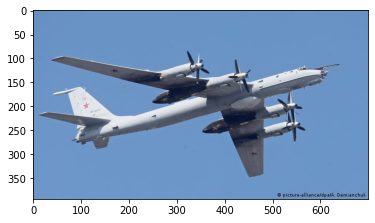

In [ ]:
# Берем изображение из Интернета

model_image_size = (416,416)
image = Image.open('/content/drive/MyDrive/Colab Notebooks/Базы/Интернет/plane.jpg')
plt.imshow (image)

(1, 416, 416, 3)


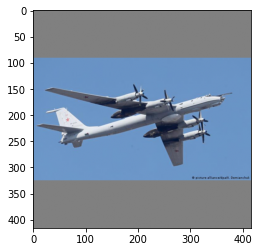

In [ ]:
# Изменяем размер картинки под input_shape

iw, ih = image.size
w, h = (416, 416)
scale = min(w / iw, h / ih)
nw = int(iw * scale)
nh = int(ih * scale)
image_for_predict = image.resize((nw, nh), Image.BICUBIC)
new_image = Image.new('RGB', (416,416), (128, 128, 128))
new_image.paste(image_for_predict, ((w - nw) // 2, (h - nh) // 2))
image_for_predict = new_image 
image_for_predict = np.array(image_for_predict) / 255.
plt.imshow(image_for_predict)
image_for_predict = image_for_predict.reshape(1, 416, 416, 3)
print (image_for_predict.shape)

In [ ]:
predict = model_YOLO.predict(image_for_predict)
num_layers = len(predict)
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]
input_shape = np.array(predict[0].shape[1:3]) * 32
image_shape = np.array([image.size[1], image.size[0]])
print(input_shape)
print(image_shape)

[416 416]
[394 700]


In [ ]:
level_anchor = 0
num_anchors = len(anchors[anchor_mask[level_anchor]])
anchors_tensor = np.reshape(anchors[anchor_mask[level_anchor]], (1,1,1,num_anchors,2))
print(anchors_tensor.shape)
print(anchors_tensor)

(1, 1, 1, 3, 2)
[[[[[116  90]
    [156 198]
    [373 326]]]]]


In [ ]:
# Массив сетки

grid_shape = predict[level_anchor].shape[1:3]
grid = []
grid_row = []
for i in range(grid_shape[0]):
  for j in range(grid_shape[1]):
    grid_row.append([j , i])
  grid.append(grid_row)
  grid_row = []
grid = np.array(grid)
grid = np.expand_dims(grid, axis=2)
print(grid.shape)

(13, 13, 1, 2)


In [ ]:
# Решейпим предикт

feats = np.reshape(predict[level_anchor], (-1, grid_shape[0], grid_shape[1], num_anchors, num_classes+5))
print(feats.shape)
print (feats[0][6][7][1])

(1, 13, 13, 3, 6)
[-0.73640376  1.0458977   0.70291346 -0.20296004 -2.2050443  11.521259  ]


In [ ]:
print (feats[0][2][2][2])

[  0.79779786   0.83879733  -0.23763666  -0.102902   -15.226503
   9.773205  ]


In [ ]:
# Функция расчета сигмоиды для вектора

def sigmoid(x):
  return 1/(1+np.exp(-x))

In [ ]:
# Получаем параметры бокса

xy_param = feats[..., :2]
box_xy = (sigmoid(xy_param) + grid)/grid_shape[::-1]

wh_param = feats[..., 2:4]
box_wh = np.exp(wh_param) * anchors_tensor / input_shape[::-1]

conf_param = feats[..., 4:5]
box_confidence = sigmoid(conf_param)

class_param = feats[...,5:]
box_class_probs = sigmoid(class_param)
print(box_xy.shape)
print(box_wh.shape)
print(box_confidence.shape)
print(box_class_probs.shape)
print(box_xy[0][6][7][1])
print(box_wh[0][6][7][1])
print(box_confidence[0][6][7][1])
print(box_class_probs[0][6][7][1])

(1, 13, 13, 3, 2)
(1, 13, 13, 3, 2)
(1, 13, 13, 3, 1)
(1, 13, 13, 3, 1)
[0.56336854 0.51846049]
[0.75736061 0.38853256]
[0.09929842]
[0.9999901]


In [ ]:
# Корректируем ограничивающие рамки

box_yx = box_xy[..., ::-1].copy()
box_hw = box_wh[..., ::-1].copy()

new_shape = np.round(image_shape * np.min(input_shape/image_shape))
offset = (input_shape-new_shape)/2./input_shape
scale = input_shape/new_shape
box_yx = (box_yx - offset) * scale
box_hw *= scale

box_mins = box_yx - (box_hw / 2.)
box_maxes = box_yx + (box_hw / 2.)
_boxes =  np.concatenate([
    box_mins[..., 0:1],
    box_mins[..., 1:2],
    box_maxes[..., 0:1],
    box_maxes[..., 1:2]
], axis=-1)
print(new_shape)
print(offset)
print(scale)
print(_boxes.shape)
print()
print(_boxes[0][6][7][1])
print(image_shape)
_boxes *= np.concatenate([image_shape, image_shape])
print(_boxes[0][6][7][1])

[234. 416.]
[0.21875 0.     ]
[1.77777778 1.        ]
(1, 13, 13, 3, 4)

[0.18745638 0.18468824 0.87818092 0.94204884]
[394 700]
[ 73.85781225 129.2817658  346.003282   659.43419097]


In [ ]:
# Получаем выходные параметры

_boxes_reshape = np.reshape(_boxes, (-1, 4))
_box_scores = box_confidence * box_class_probs
_box_scores_reshape = np.reshape(_box_scores, (-1, num_classes))
print(_boxes_reshape.shape)
print(_box_scores_reshape.shape)
print(_boxes_reshape[256])
print(_box_scores_reshape[256])

(507, 4)
(507, 1)
[ 73.85781225 129.2817658  346.003282   659.43419097]
[0.09929743]


In [ ]:
mask = _box_scores_reshape >= 0.001
print(np.where(mask == True))

(array([176, 212, 213, 214, 215, 218, 243, 244, 247, 250, 251, 252, 253,
       254, 256, 257, 259, 262, 288, 289, 290, 291, 292, 293, 294, 295,
       296, 298, 332]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0]))


In [ ]:
_boxes_out = _boxes_reshape[mask[:,0]]
_scores_out = _box_scores_reshape[:, 0][mask[:,0]] 
classes_out = np.ones_like(_scores_out,'int32') * 0
print(_boxes_out)
print(_scores_out)
print (classes_out)

[[-121.53049284    4.03928764  317.72323909  682.64269547]
 [ -21.01205378    1.00586555  340.40619563  638.79537809]
 [  95.15434616  -39.00632148  224.48453911  733.91436453]
 [  41.38785764   39.9653609   285.46734213  653.75039532]
 [ -35.79777469    4.387581    350.08483757  684.31973538]
 [ -60.90207959   74.49357806  359.72498012  685.6091715 ]
 [ 106.68464116   42.08024471  288.42230509  362.82518546]
 [  74.70696679    9.25212497  307.75604752  393.94737625]
 [  71.35173128   15.82211886  316.91927595  489.05297254]
 [  75.98257025   38.44595895  326.79670687  572.19344721]
 [  52.82646548   -3.28351758  350.40640011  643.10218228]
 [ 122.01448797   78.41804291  286.11840357  620.85887068]
 [  83.68418194   92.23482557  334.52069362  605.84879019]
 [  49.96815639    9.81793037  367.65273662  667.94963296]
 [  73.85781225  129.2817658   346.003282    659.43419097]
 [  50.43372302   66.81401864  366.28168231  692.21388059]
 [  76.33833947  213.90168237  345.21315689  663.9188351

In [ ]:
font = ImageFont.truetype(font=path + 'font.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
thickness = (image.size[0] + image.size[1]) // 300

0
Самолеты 0.00 (6, 97) (683, 394)
0
Самолеты 0.01 (205, 95) (676, 367)
0
Самолеты 0.08 (62, 82) (700, 387)
0
Самолеты 0.06 (125, 105) (667, 353)
0
Самолеты 0.00 (142, 146) (650, 331)
0
Самолеты 0.84 (7, 81) (681, 388)
0
Самолеты 0.32 (96, 108) (600, 354)
0
Самолеты 0.03 (93, 147) (600, 336)
0
Самолеты 0.14 (0, 72) (642, 394)
0
Самолеты 0.01 (62, 108) (545, 359)
0
Самолеты 0.01 (61, 144) (530, 326)
0
Самолеты 0.00 (312, 83) (679, 339)
0
Самолеты 0.02 (214, 76) (664, 345)
0
Самолеты 0.38 (67, 50) (692, 366)
0
Самолеты 0.10 (129, 74) (659, 346)
0
Самолеты 1.00 (10, 50) (668, 368)
0
Самолеты 0.74 (92, 84) (606, 335)
0
Самолеты 0.01 (78, 122) (621, 286)
0
Самолеты 0.98 (0, 53) (643, 350)
0
Самолеты 0.16 (38, 76) (572, 327)
0
Самолеты 0.00 (16, 71) (489, 317)
0
Самолеты 0.01 (9, 75) (394, 308)
0
Самолеты 0.00 (42, 107) (363, 288)
0
Самолеты 0.00 (74, 0) (686, 360)
0
Самолеты 0.36 (4, 0) (684, 350)
0
Самолеты 0.00 (40, 41) (654, 285)
0
Самолеты 0.01 (0, 95) (700, 224)
0
Самолеты 0.08 (1, 0) 

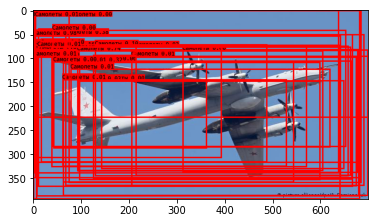

In [ ]:
image_pred = image.copy()
for i, c in reversed(list(enumerate(classes_out))):
  print(c)
  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[c]
  box = _boxes_out[i]
  score = _scores_out[i]

  label = '{} {:.2f}'.format(predicted_class, score)
  label_size = draw.textsize(label, font)

  top, left, bottom, right = box
  top = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
  print(label, (left, top), (right, bottom))

  if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
  else:
      text_origin = np.array([left, top + 1])
  
  for i in range(thickness):
      draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline=colors[c])
  draw.rectangle(
      [tuple(text_origin), tuple(text_origin + label_size)],
      fill=colors[c])
  draw.text(text_origin, label, fill=(0, 0, 0), font=font)
  del draw
image_pred.save('new_image.jpg')
plt.imshow(image_pred)